In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from pysal.explore import esda
from libpysal.weights import Queen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:

df = pd.read_csv('/content/drive/My Drive/Chicago_Crimes_2012_to_2017.csv')


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Latitude','Longitude','Date','Community Area'])
df = df.query('41.64 <= Latitude <= 42.02 and -87.94 <= Longitude <= -87.52')


In [ ]:

# Feature engineering
df['X_km'] = df['Latitude']  * 111.0
df['Y_km'] = df['Longitude'] * 111.0 * np.cos(np.deg2rad(df['Latitude']))
secs = df['Date'].astype('int64') // 1_000_000_000
df['Days'] = ((secs - secs.min()) / (3600*24)).astype(float)
df['Hour'] = df['Date'].dt.hour
df['Hour_sin'] = np.sin(2*np.pi*df['Hour']/24.)
df['Hour_cos'] = np.cos(2*np.pi*df['Hour']/24.)
dow = pd.get_dummies(df['Date'].dt.dayofweek, prefix='DoW', dtype='int8')
df = pd.concat([df, dow], axis=1)


In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, train_size=10000, random_state=42)
idx, _ = next(sss.split(df, df['Community Area']))
df_s = df.iloc[idx].copy()


In [ ]:
coord_std = StandardScaler().fit_transform(df_s[['X_km','Y_km']])
days_std  = StandardScaler().fit_transform(df_s[['Days']])
hour_std  = StandardScaler().fit_transform(df_s[['Hour_sin','Hour_cos']])
topN = 8
crime_dummy = pd.get_dummies(
    df['Primary Type'].where(
        df['Primary Type'].isin(df['Primary Type'].value_counts().nlargest(topN).index),
        other='OTHER'),
    prefix='Crime', dtype='int8')
crime_block = crime_dummy.loc[df_s.index].to_numpy(dtype=float)
alpha = 0.1
beta  = 0.12
gamma = 1.5
X = np.hstack([coord_std, alpha * days_std, beta * hour_std, df_s.filter(like='DoW_').to_numpy(dtype=float), gamma * crime_block])


In [ ]:

opt = OPTICS(min_samples=25, xi=0.08, cluster_method='xi', metric='euclidean', n_jobs=-1).fit(X)
df_s['TOPTICS_Cluster'] = opt.labels_


In [ ]:

from sklearn.metrics import silhouette_score
mask = df_s['TOPTICS_Cluster'] != -1
sil = silhouette_score(X[mask], df_s.loc[mask,'TOPTICS_Cluster'])
print(f"Silhouette (non-noise): {sil:.3f}")


Silhouette (non-noise): 0.215


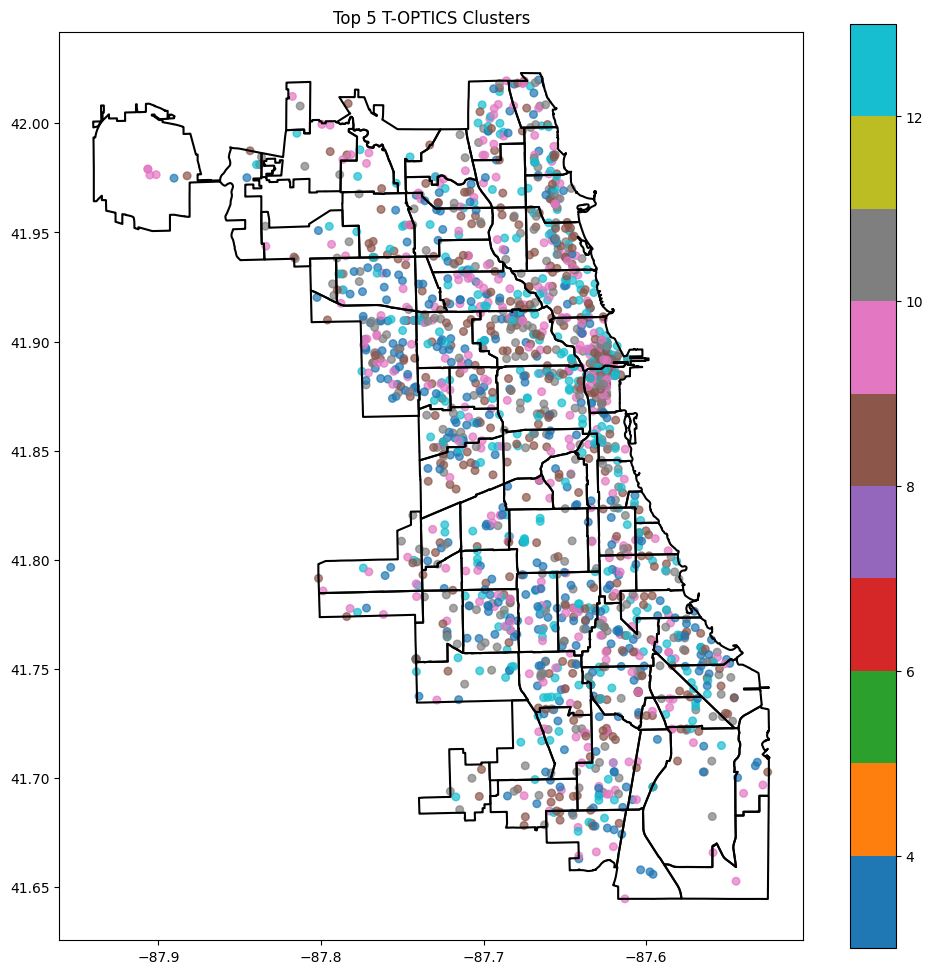

In [ ]:

top_clusters = valid_clusters['TOPTICS_Cluster'].value_counts().index[:5]
filtered_clusters = valid_clusters[valid_clusters['TOPTICS_Cluster'].isin(top_clusters)]

fig, ax = plt.subplots(figsize=(12,12))
community_gdf.boundary.plot(ax=ax, color='black')
gdf_points_valid = gpd.GeoDataFrame(filtered_clusters, geometry=gpd.points_from_xy(filtered_clusters.Longitude, filtered_clusters.Latitude), crs='EPSG:4326')
gdf_points_valid.plot(ax=ax, column='TOPTICS_Cluster', cmap='tab10', legend=True, alpha=0.7, markersize=30)
ax.set_title('Top 5 T-OPTICS Clusters')
plt.show()


In [ ]:

community_gdf = gpd.read_file("https://data.cityofchicago.org/resource/igwz-8jzy.geojson")
community_gdf['area_numbe'] = pd.to_numeric(community_gdf['area_numbe'], errors='coerce')


In [ ]:

# Spatial join points to polygons
gdf_points = gpd.GeoDataFrame(df_s, geometry=gpd.points_from_xy(df_s.Longitude, df_s.Latitude), crs='EPSG:4326')
joined = gpd.sjoin(gdf_points, community_gdf[['geometry','area_numbe']], how='left')
print(joined[['TOPTICS_Cluster','area_numbe']].head())


        TOPTICS_Cluster  area_numbe
223572                0        38.0
254369               -1        58.0
375474               46        29.0
275834               18        61.0
117821               43        68.0


In [ ]:

agg = joined.groupby('area_numbe')['TOPTICS_Cluster'].value_counts().unstack(fill_value=0)
agg['total_incidents'] = agg.sum(axis=1)
print(agg.head())


TOPTICS_Cluster  -1  0  1  2  3  4  5  6  7  8  ...  53  54  55  56  57  58  \
area_numbe                                      ...                           
1.0              28  1  3  5  4  5  2  0  2  3  ...   0   0   0   0   0   0   
2.0              21  2  2  3  4  0  5  0  4  5  ...   2   0   0   0   0   0   
3.0              32  1  6  4  4  5  2  0  2  5  ...   0   1   2   0   0   0   
4.0              17  2  2  1  2  4  3  0  1  3  ...   2   3   0   0   0   0   
5.0               7  1  1  1  1  0  3  0  0  3  ...   2   1   2   0   0   0   

TOPTICS_Cluster  59  60  61  total_incidents  
area_numbe                                    
1.0               0   0   0              116  
2.0               0   0   2              121  
3.0               0   0   1              139  
4.0               1   0   0               73  
5.0               1   0   0               56  

[5 rows x 64 columns]


In [ ]:

gdf_agg = community_gdf.merge(agg, left_on='area_numbe', right_index=True, how='left')
gdf_agg = gdf_agg.fillna(0)


In [ ]:
# Computing Moran's I on total incidents
w = Queen.from_dataframe(gdf_agg)
moran = esda.Moran(gdf_agg['total_incidents'], w)
print(f"Moran's I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")


Moran's I: 0.3522, p-value: 0.0010


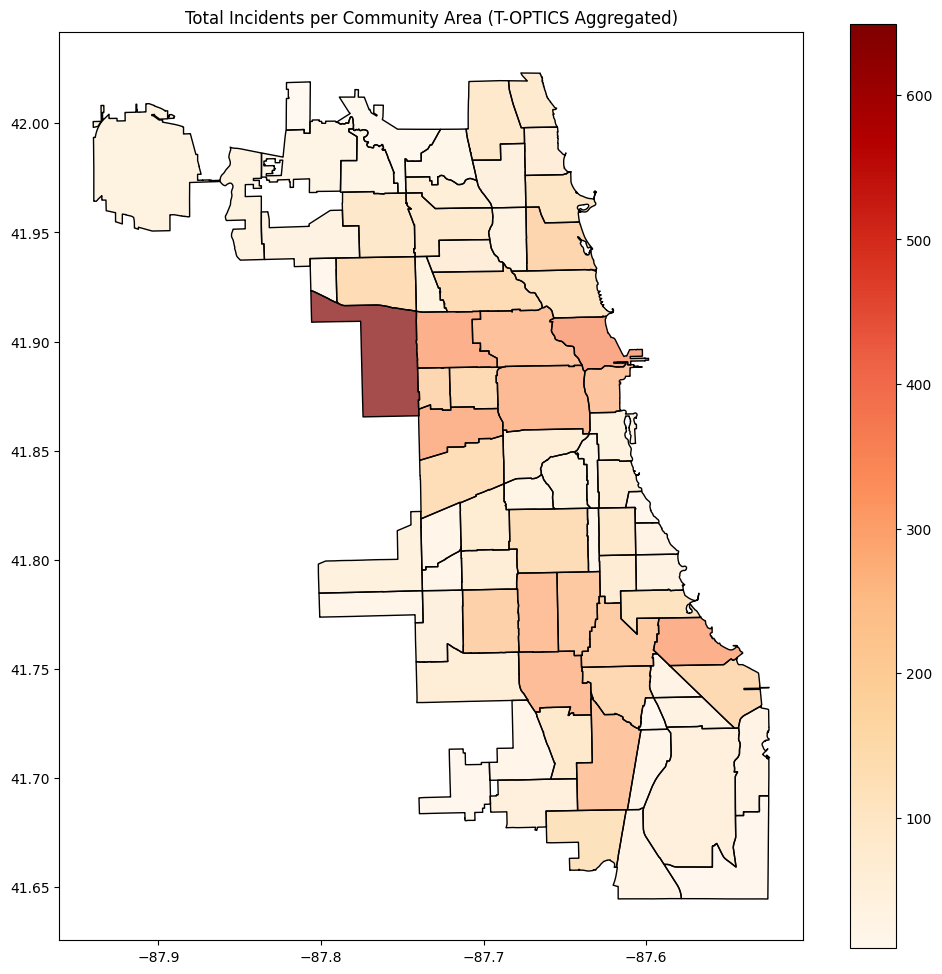

In [ ]:

fig, ax = plt.subplots(figsize=(12,12))
gdf_agg.boundary.plot(ax=ax, color='black', linewidth=1)
gdf_agg.plot(ax=ax, column='total_incidents', cmap='OrRd', legend=True, alpha=0.7)
ax.set_title('Total Incidents per Community Area (T-OPTICS Aggregated)')
plt.show()


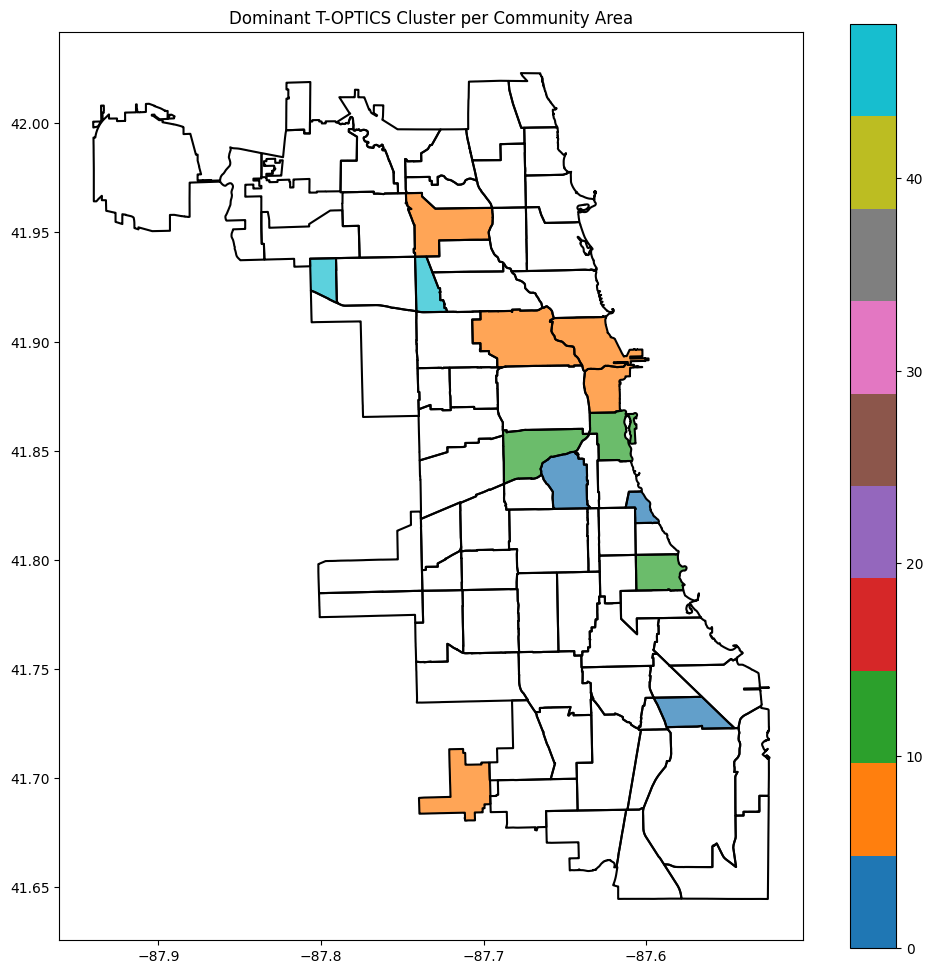

In [ ]:
# Create dominant clusters without noise
agg['dominant_cluster_clean'] = agg.drop(columns=['total_incidents']).idxmax(axis=1)
gdf_agg = community_gdf.merge(agg, left_on='area_numbe', right_index=True, how='left')
gdf_agg = gdf_agg.fillna(0)
gdf_agg['dominant_cluster_clean'] = gdf_agg['dominant_cluster_clean'].replace(-1, np.nan)
fig, ax = plt.subplots(figsize=(12, 12))
community_gdf.boundary.plot(ax=ax, color='black')
gdf_agg.dropna(subset=['dominant_cluster_clean']).plot(
    ax=ax, column='dominant_cluster_clean', cmap='tab10', legend=True, alpha=0.7
)
ax.set_title('Dominant T-OPTICS Cluster')
plt.show()


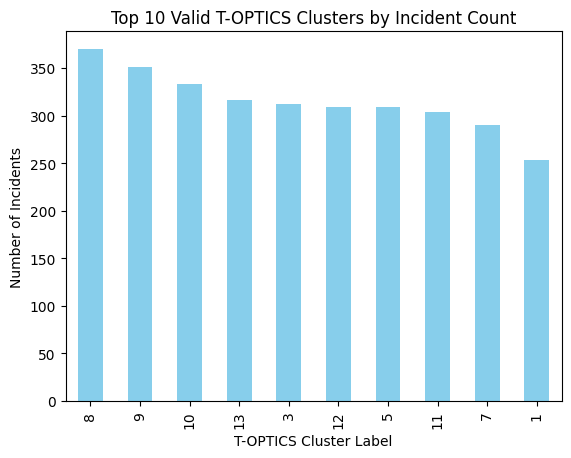

In [ ]:
cluster_totals = agg.drop(columns=['total_incidents']).sum(axis=0)
valid_clusters_only = cluster_totals[cluster_totals.index != -1]
top_clusters_valid = valid_clusters_only.sort_values(ascending=False).head(10)
top_clusters_valid.plot(kind='bar', color='skyblue')
plt.xlabel('T-OPTICS Cluster Label')
plt.ylabel('Number of Incidents')
plt.title('Top 10 Valid T-OPTICS Clusters by Incident Count')
plt.show()


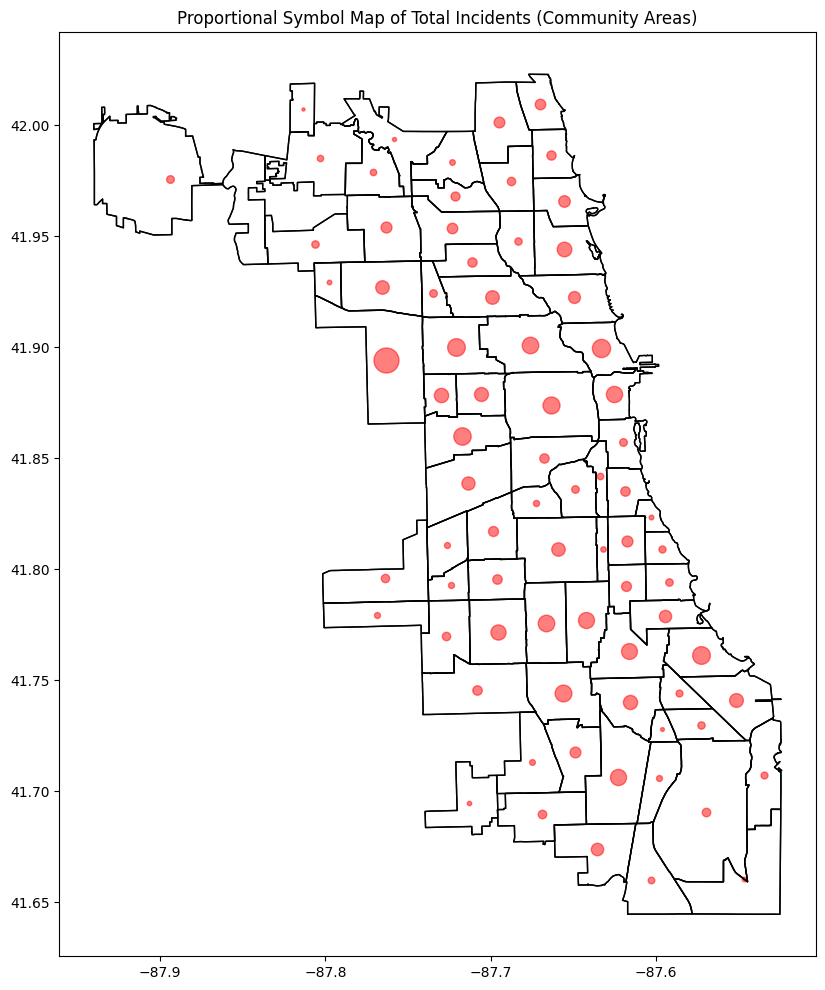

In [ ]:
gdf_agg['centroid'] = gdf_agg.geometry.centroid
fig, ax = plt.subplots(figsize=(12,12))
gdf_agg.boundary.plot(ax=ax, color='black', linewidth=1)
gdf_agg.plot(ax=ax, color='white', edgecolor='black')
gdf_agg.apply(lambda row: ax.scatter(row['centroid'].x, row['centroid'].y,
                                     s=row['total_incidents']*0.5, color='red', alpha=0.5), axis=1)
ax.set_title('Proportional Symbol Map of Total Incidents (Community Areas)')
plt.show()


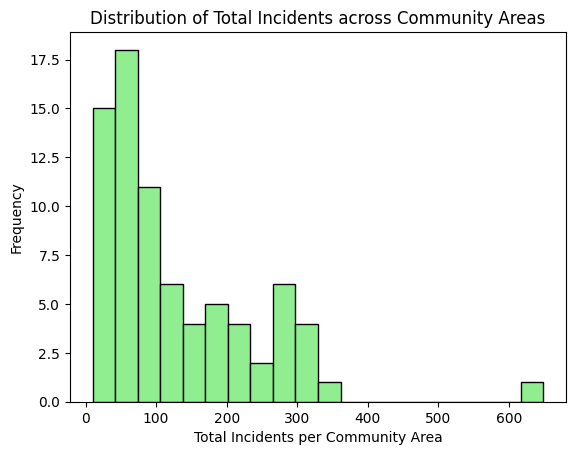

In [ ]:

gdf_agg['total_incidents'].plot(kind='hist', bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Total Incidents per Community Area')
plt.ylabel('Frequency')
plt.title('Distribution of Total Incidents across Community Areas')
plt.show()


In [ ]:

valid_clusters = df_s[df_s['TOPTICS_Cluster'] != -1].copy()


In [ ]:
# Grouping small clusters as 'Other'
cluster_counts = valid_clusters['TOPTICS_Cluster'].value_counts()
small_clusters = cluster_counts[cluster_counts < 50].index
valid_clusters['Cluster_Label'] = valid_clusters['TOPTICS_Cluster'].apply(lambda x: 'Other' if x in small_clusters else x)


In [ ]:
summary = valid_clusters.groupby('Cluster_Label').agg(
    count=('TOPTICS_Cluster','count'),
    dominant_crime=('Primary Type', lambda x: x.value_counts().idxmax())
).sort_values('count', ascending=False)
print(summary)


               count       dominant_crime
Cluster_Label                            
Other            415        OTHER OFFENSE
8                372                THEFT
9                352                THEFT
10               335                THEFT
13               316                THEFT
3                312              BATTERY
5                310              BATTERY
12               310                THEFT
11               304                THEFT
7                290                THEFT
1                253              BATTERY
2                247              BATTERY
44               245  MOTOR VEHICLE THEFT
46               244              ROBBERY
4                239              BATTERY
0                238              BATTERY
43               232  MOTOR VEHICLE THEFT
48               217  MOTOR VEHICLE THEFT
29               209      CRIMINAL DAMAGE
49               200              ROBBERY
47               194              ROBBERY
28               179      CRIMINAL

In [ ]:
# co-location matrix at neighborhood level
crime_matrix = pd.crosstab(joined['area_numbe'], df_s.loc[joined.index, 'Primary Type'])
print(crime_matrix.head())


Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  CRIM SEXUAL ASSAULT  \
area_numbe                                                             
1.0               0        6       26         5                    0   
2.0               0        5       18         8                    1   
3.0               0        8       24         6                    1   
4.0               0        3       18         7                    0   
5.0               0        1        7         7                    0   

Primary Type  CRIMINAL DAMAGE  CRIMINAL TRESPASS  DECEPTIVE PRACTICE  \
area_numbe                                                             
1.0                        19                  6                   2   
2.0                        14                  5                   7   
3.0                        10                  9                  10   
4.0                         9                  3                   3   
5.0                         4                  2               

In [ ]:
#co-location pairs (support + confidence)
from itertools import combinations
colocations = []
total_areas = len(crime_matrix)
for crime1, crime2 in combinations(crime_matrix.columns, 2):
    both_present = (crime_matrix[crime1] > 0) & (crime_matrix[crime2] > 0)
    support = both_present.sum() / total_areas
    confidence = support / ((crime_matrix[crime1] > 0).sum() / total_areas)
    colocations.append((crime1, crime2, support, confidence))
coloc_df = pd.DataFrame(colocations, columns=['Crime1','Crime2','Support','Confidence']).sort_values('Support', ascending=False)
print(coloc_df.head(10))


              Crime1           Crime2   Support  Confidence
139  CRIMINAL DAMAGE            THEFT  0.961039    1.000000
73           BATTERY            THEFT  0.961039    1.000000
328    OTHER OFFENSE            THEFT  0.961039    1.000000
96          BURGLARY            THEFT  0.948052    1.000000
133  CRIMINAL DAMAGE    OTHER OFFENSE  0.948052    0.986486
90          BURGLARY    OTHER OFFENSE  0.935065    0.986301
53           BATTERY  CRIMINAL DAMAGE  0.935065    0.972973
67           BATTERY    OTHER OFFENSE  0.922078    0.959459
49           ASSAULT            THEFT  0.922078    1.000000
304        NARCOTICS            THEFT  0.922078    1.000000


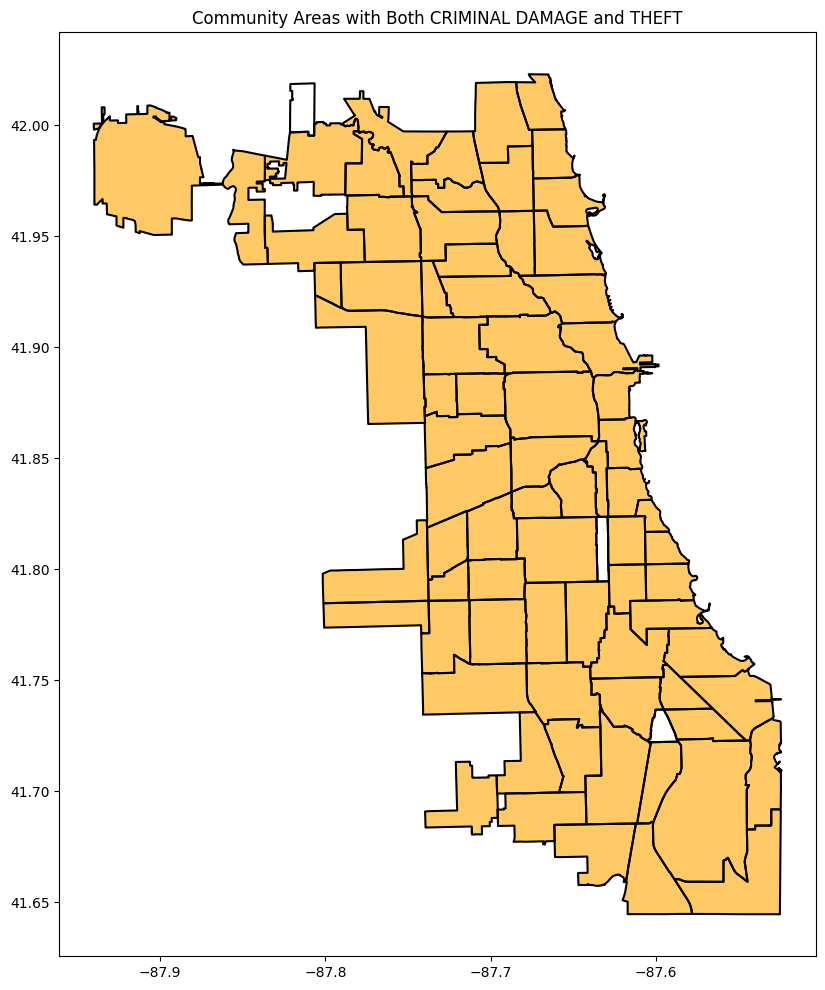

In [ ]:
top_pair = coloc_df.iloc[0][['Crime1','Crime2']]
areas_both = crime_matrix[(crime_matrix[top_pair['Crime1']] > 0) & (crime_matrix[top_pair['Crime2']] > 0)].index.tolist()
fig, ax = plt.subplots(figsize=(12,12))
community_gdf.boundary.plot(ax=ax, color='black')
highlight = community_gdf[community_gdf['area_numbe'].isin(areas_both)]
highlight.plot(ax=ax, color='orange', alpha=0.6)
ax.set_title(f"Community Areas with Both {top_pair['Crime1']} and {top_pair['Crime2']}")
plt.show()
